# 1 Introduction
This paper will demonstrate how time series analysis can be applied in analysing daily price movements of a stock of tech giant, Nvidia Corporation (NVDA). Historical data of Nvidia’s stock price was collected, spanning the last 5 years (July 21st, 2016, July 21st, 2021), from the Yahoo Finance website. Contents of the dataset include daily high, low, open, close, and adjusted close prices of the NVDA stock. The analysis of this paper will focus on the closing price (close).


In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats


#Time Series Libraries and functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA

In [2]:
#Load data
data = pd.read_csv('C:\\Users\\Inno Mvula\\Desktop\\Kaggle files\\Projects - Time Series\\Nvidia Stock Prices\\NVDA.csv')

#make a copy
rdata = data[:]

In [3]:
rdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [4]:
#Convert Date column to datetime format
rdata['Date'] = pd.to_datetime(rdata['Date'])
rdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1258 non-null   datetime64[ns]
 1   Open       1258 non-null   float64       
 2   High       1258 non-null   float64       
 3   Low        1258 non-null   float64       
 4   Close      1258 non-null   float64       
 5   Adj Close  1258 non-null   float64       
 6   Volume     1258 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.9 KB


# 2 Preliminary Analysis
The first step in any time series analysis is to observe the stationarity of the data. What this means is that the various statistical properties of the data, referring to the mean and variance, remain relatively stable over time. This is an import feature for data to have in a time series analysis as many forecasting models rely on stationarity and make the models more reliable.So before proceeding to fit a model and forecast future prices it is important we identify whether a time series process is stationary or non-stationary. The following 3 approaches were taken to observe the stationarity of the closing prices.
- Visualization of time series plots
- Review of summary statistics
- Run Augmented Dickey-Fuller test

#### Visualization of Time Series Plots

<AxesSubplot:xlabel='Date', ylabel='Close'>

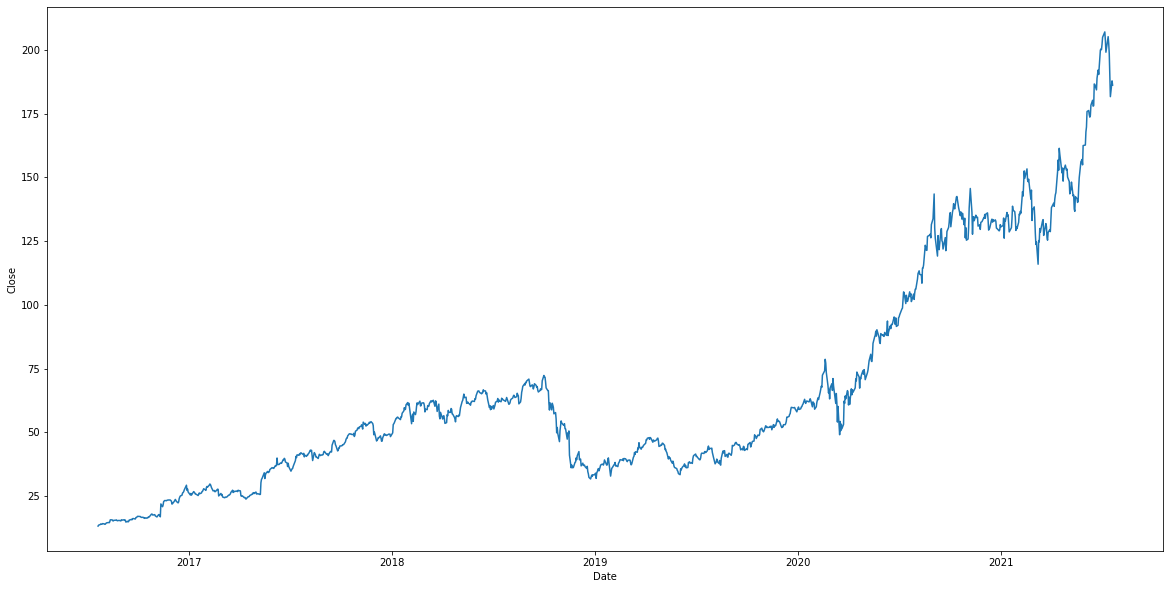

In [5]:
plt.figure(figsize=(20, 10))
sns.lineplot(data = rdata, x = "Date", y = "Close")

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1440x720 with 0 Axes>

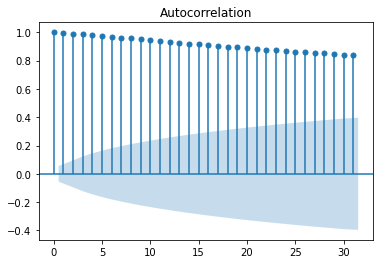

In [6]:
cprices = rdata['Close']
plt.figure(figsize=(20, 10))
plot_acf(cprices)
plt.show

#### Summary Statistics

<function matplotlib.pyplot.show(close=None, block=None)>

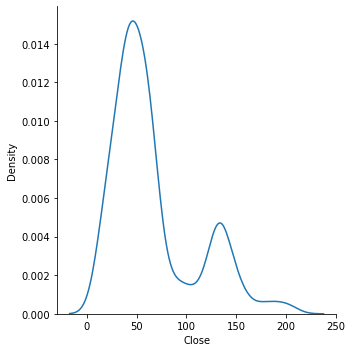

In [7]:
#2. Review Summary Statistics. Observe any changes in the mean and vaiance
sns.displot(cprices, kind = 'kde')
plt.show

In [8]:
split = round(len(cprices)/2)
cprice1 = cprices[0:split]
m1 = cprice1.mean()
v1 = stats.variance(cprice1)
cprice2 = cprices[split:]
m2 = cprice2.mean()
v2 = stats.variance(cprice2)

sum_dict = {'stat': ['Mean', 'Variance'], 'group1': [m1, v1], 'group2': [m2, v2]}
sumstats = pd.DataFrame(sum_dict)
sumstats

,stat,group1,group2
0,Mean,42.203279,89.695139
1,Variance,285.979223,2160.940782


#### Augmented Dickey-Fuller Test for stationarity

In [9]:
print('Augmented Dickey-Fuller Test')
adftest = adfuller(cprices)
adfresult = pd.Series(adftest[0:4], index = ['Test Statistic', 'P-value', 'Lags', 'Observations'])
crits = pd.Series(adftest[4])
adfresult = pd.concat([adfresult, crits])
adfresult

Augmented Dickey-Fuller Test


Test Statistic       1.291581
P-value              0.996561
Lags                13.000000
Observations      1244.000000
1%                  -3.435618
5%                  -2.863866
10%                 -2.568008
dtype: float64

## 2.1 Applying log transformation and differencing
- Log transformation can help stabilize the variance
- Differencing can help stabilize the mean which can reduce or remove seasonality and trends
- Together these two transformations help in transforming a time series process from non-stationary to stationary

#### Visualization of Time Series Plots

In [10]:
lclose = np.log1p(cprices)
lcprices = lclose.diff()
rdata['lcprices'] = lcprices

<function matplotlib.pyplot.show(close=None, block=None)>

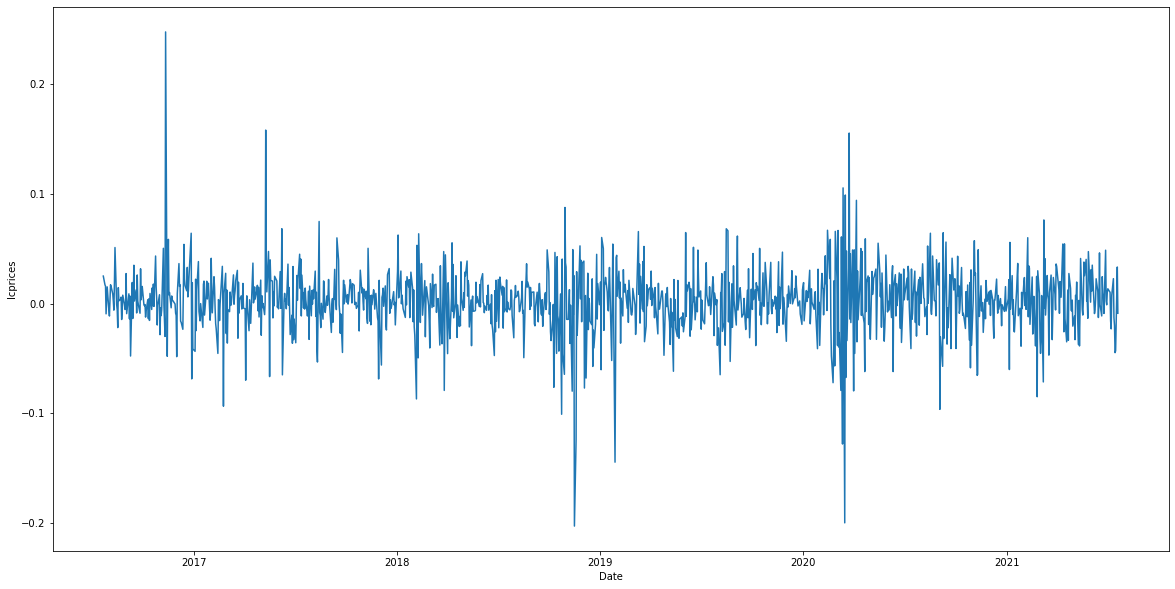

In [11]:
plt.figure(figsize=(20, 10))
sns.lineplot(data = rdata, x = "Date", y = "lcprices")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1440x720 with 0 Axes>

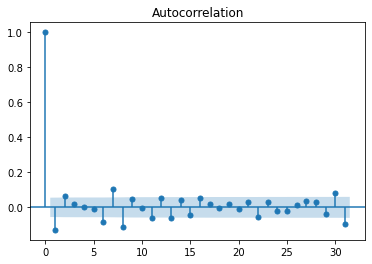

In [12]:
plt.figure(figsize=(20, 10))
plot_acf(lcprices[1:])
plt.show

#### Summary Statistics

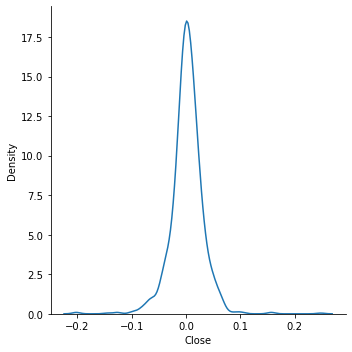

In [13]:
#2. Review Summary Statistics. Observe any changes in the mean and vaiance
sns.displot(lcprices, kind = 'kde')

In [14]:
split = round(len(lcprices)/2)
lcprice1 = lcprices[1:split]
m1 = lcprice1.mean()
v1 = stats.variance(lcprice1)
lcprice2 = lcprices[split:]
m2 = lcprice2.mean()
v2 = stats.variance(lcprice2)

sum_dict = {'stat': ['Mean', 'Variance'], 'group1': [m1, v1], 'group2': [m2, v2]}
sumstats = pd.DataFrame(sum_dict)
sumstats

,stat,group1,group2
0,Mean,0.001647,0.002444
1,Variance,0.000827,0.000911


#### Augmented Dickey-Fuller Test for stationarity

In [15]:
print('Augmented Dickey-Fuller Test')
adftest1 = adfuller(lcprices[1:])
adfresult1 = pd.Series(adftest1[0:4], index = ['Test Statistic', 'P-value', 'Lags', 'Observations'])
crits1 = pd.Series(adftest1[4])
adfresult1 = pd.concat([adfresult1, crits1])
adfresult1

Augmented Dickey-Fuller Test


Test Statistic   -1.327700e+01
P-value           7.829005e-25
Lags              7.000000e+00
Observations      1.249000e+03
1%               -3.435596e+00
5%               -2.863857e+00
10%              -2.568004e+00
dtype: float64

# 3 Model Fitting

#### Testing for white noise
- Before fitting a model for use in forecasting we will test to see if our time series process can be used for forecasting. This will be done by testing for white noise.
- White noise processes have have constant variances and means as well as autocorrelations equal to zero
- Forecasting is not possible with a white noise process hence why we test for it
- We use the ljung-box test to check for white noise
- This null hypothesis for the ljung-box test states that autocorrelations are equal to zero. If null hypothesis holds then the time series process is a white noise process

In [17]:
acorr_ljungbox(lcprices[1:], lags = [10], return_df = True)

,lb_stat,lb_pvalue
10,68.305268,9.408177e-11


- Given the values above we can reject the null hypothesis

#### Identify and Fitting an Appropriate Model

<function matplotlib.pyplot.show(close=None, block=None)>

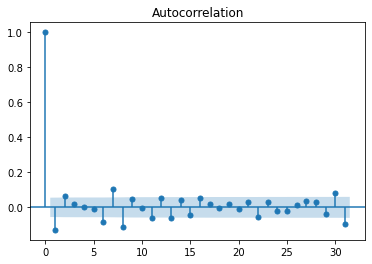

In [18]:
plot_acf(lcprices[1:])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

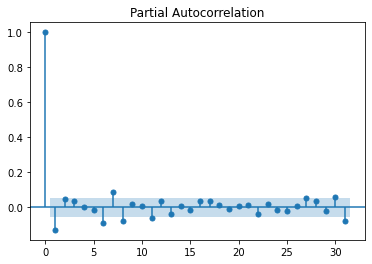

In [19]:
plot_pacf(lcprices[1:])
plt.show

- Based on the Pacf and Acf graphs its clear to see that the model may be MA(1) evident by The very high lag followed by lags closer to zero
- We can try a couple models ARMA(0,1) and ARMA(1,1)

In [20]:
mod = ARIMA(lcprices[1:], order=(0, 0, 1))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1257
Model:                 ARIMA(0, 0, 1)   Log Likelihood                2656.604
Date:                Wed, 21 Jul 2021   AIC                          -5307.208
Time:                        18:19:16   BIC                          -5291.798
Sample:                             0   HQIC                         -5301.416
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.740      0.006       0.001       0.003
ma.L1         -0.1154      0.017     -6.797      0.000      -0.149      -0.082
sigma2         0.0009   1.44e-05     59.223      0.0

In [21]:
mod2 = ARIMA(lcprices[1:], order=(1, 0, 1))
res2 = mod2.fit()
print(res2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1257
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2658.557
Date:                Wed, 21 Jul 2021   AIC                          -5309.114
Time:                        18:19:20   BIC                          -5288.568
Sample:                             0   HQIC                         -5301.392
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.638      0.008       0.001       0.004
ar.L1         -0.3590      0.150     -2.396      0.017      -0.653      -0.065
ma.L1          0.2339      0.157      1.486      0.1